# Generate occupancy plots from combined sgRNA counts

## 1. Import dependencies

In [1]:
import sys,os, glob
import shutil

import fuzzysearch
import re
from collections import Counter, OrderedDict

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
plt.rcParams['pdf.fonttype'] = 42

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'


from Bio import SeqIO, SeqRecord
from Bio.Seq import Seq
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIWWW, NCBIXML

import seaborn as sns

from pycirclize import Circos
from pycirclize.parser import Genbank
from pycirclize.utils import load_prokaryote_example_file

/Users/slopez/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Plot gRNA coverage of the _E. coli_ genome 


In [2]:
from pycirclize import Circos
from pycirclize.utils import fetch_genbank_by_accid
from pycirclize.parser import Genbank

# Download `NC_002483` E.coli MG1655 genome from genbank
gbk_fetch_data = fetch_genbank_by_accid("NC_000913.3")
gbk = Genbank(gbk_fetch_data)

### scenarios:
```
1. s < e :
either e (28) - s (9) == 19 --> guide is not inverted, doesn't cross start finish
    if e - s == 19:
        start = s
        end = e
        l[start:end] = l[start:end] + c
        
or e (18) - s (9) != 19 --> guide is inverted and crosses the start-finish line
    else: 
        l[e:genome_size-1] = l[e:genome_size-1] + c
        l[0:s] = l[0:s] + c   
        
2. s > e:
either s (28) - e (9)  == 19 --> guide is inverted, doesn't cross the start-finish
    if s-e == 19:
        start = e
        end = s 
        l[start:end] = l[start:end] + c
        
or s (29) - s (19) !=19 --> guide is not inverted, but crossed the start-finish
    else:
        l[s:genome_size-1] = l[s:genome_size-1] + c
        l[0:e] = l[0:e] + c  
```       


In [3]:
for file_ in glob.glob("*.fasta.xml"):
    print (file_)

LC_s1r2_screen_18_04_2023.fasta.xml
MG_s1r3_screen_18_04_2023.fasta.xml
MG_s1r1_screen_16_04_2023.fasta.xml
LC_+565_+R2_19_10_2023.fasta.xml
LC_s1r3_screen_18_04_2023.fasta.xml
LC_s1r1_screen_16_04_2023.fasta.xml
MG_s1r2_screen_18_04_2023.fasta.xml
MG_+565_+R1_19_10_2023.fasta.xml
LC_lib_pre_19_10_2023.fasta.xml
lib_in_screen_18_04_2023.fasta.xml
LC_+565_+R3_19_10_2023.fasta.xml
MG_lib_pre_19_10_2023.fasta.xml
MG_+565_+R2_19_10_2023.fasta.xml
LC_s1r2_screen_16_04_2023.fasta.xml
MG_s1r1_screen_18_04_2023.fasta.xml
MG_s1r3_screen_16_04_2023.fasta.xml
LC_+565_+R1_19_10_2023.fasta.xml
lib_in_screen_16_04_2023.fasta.xml
LC_s1r1_screen_18_04_2023.fasta.xml
MG_+565_+R3_19_10_2023.fasta.xml
LC_s1r3_screen_16_04_2023.fasta.xml
MG_s1r2_screen_16_04_2023.fasta.xml


In [4]:
genome_size = 4641652

occupancy_all = {}

for file_ in glob.glob("*.fasta.xml"):
    if str(file_) != 'nan': 
        occupancy = np.zeros(genome_size)
        print (file_)
        result_handle = open(file_)
        blast_records = NCBIXML.parse(result_handle)
        blast_records = list(blast_records)
        guide_count = 0
        for r in blast_records:
            guide, count = r.query.split('-')[-2], float(r.query.split('-')[-1])
            if len(list(r.alignments))>0:
                s,e = int(r.alignments[0].hsps[0].sbjct_start), int(r.alignments[0].hsps[0].sbjct_end)
                if e > s:
                    if e - s == 19:
                        start = s-1
                        end = e
                        occupancy[start:end] = occupancy[start:end] + count
                    else: 
                        if s+19>=genome_size:
                            print ('alert e>s')
                            print (e,s)
                            occupancy[e-1:genome_size] = occupancy[e-1:genome_size] + count
                            occupancy[0:s] = occupancy[0:s] + count  
                        else:
                            pass
                else:
                    if s-e == 19:
                        start = e-1
                        end = s 
                        occupancy[start:end] = occupancy[start:end] + count

                    else:
                        if e+19>=genome_size:
                            print ('alert s>e')
                            print (e,s)
                            occupancy[s-1:genome_size] = occupancy[s-1:genome_size] + count
                            occupancy[0:e] = occupancy[0:e] + count 
                        else:
                            pass
                guide_count += count
        occupancy = occupancy / int(guide_count)
        occupancy_all[file_] = occupancy

LC_s1r2_screen_18_04_2023.fasta.xml
MG_s1r3_screen_18_04_2023.fasta.xml
MG_s1r1_screen_16_04_2023.fasta.xml
LC_+565_+R2_19_10_2023.fasta.xml
LC_s1r3_screen_18_04_2023.fasta.xml
LC_s1r1_screen_16_04_2023.fasta.xml
MG_s1r2_screen_18_04_2023.fasta.xml
MG_+565_+R1_19_10_2023.fasta.xml
LC_lib_pre_19_10_2023.fasta.xml
lib_in_screen_18_04_2023.fasta.xml
LC_+565_+R3_19_10_2023.fasta.xml
MG_lib_pre_19_10_2023.fasta.xml
MG_+565_+R2_19_10_2023.fasta.xml
LC_s1r2_screen_16_04_2023.fasta.xml
MG_s1r1_screen_18_04_2023.fasta.xml
MG_s1r3_screen_16_04_2023.fasta.xml
LC_+565_+R1_19_10_2023.fasta.xml
lib_in_screen_16_04_2023.fasta.xml
LC_s1r1_screen_18_04_2023.fasta.xml
MG_+565_+R3_19_10_2023.fasta.xml
LC_s1r3_screen_16_04_2023.fasta.xml
MG_s1r2_screen_16_04_2023.fasta.xml


In [6]:
occupancy_all['LC_s1r1_screen_16_04_2023.fasta.xml'][801190:801320]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00010855, 0.00010855, 0.00010855, 0.00010855, 0.00010855,
       0.00010855, 0.00010855, 0.00010855, 0.00010855, 0.00010855,
       0.00010855, 0.00010855, 0.00010855, 0.00010855, 0.00010855,
       0.00010855, 0.00010855, 0.00010855, 0.00010855, 0.00010855,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [7]:
def sliding_mean(occupancy, ws, ss):
        pos_list, fc_list = [], []
        window_size = int(len(occupancy) / ws) # default: 10000
        step_size = int(len(occupancy) / ss) # default: 20000
        pos_list = list(range(0, len(occupancy), step_size)) + [len(occupancy)]
        for pos in pos_list:
            window_start_pos = pos - int(window_size / 2)
            window_end_pos = pos + int(window_size / 2)
            window_start_pos = 0 if window_start_pos < 0 else window_start_pos
            window_end_pos = len(occupancy) if window_end_pos > len(occupancy) else window_end_pos
            subseq = occupancy[window_start_pos:window_end_pos]
            fc = np.mean(subseq, axis = 0)
            fc_list.append(fc)
        return (np.array(pos_list), np.array(fc_list))

In [8]:
## take the average of the occupancies
occupancy_in_LC = np.mean(np.concatenate((occupancy_all['LC_lib_pre_19_10_2023.fasta.xml'], 
                                           occupancy_all['lib_in_screen_16_04_2023.fasta.xml'],
                                           occupancy_all['lib_in_screen_18_04_2023.fasta.xml'])).reshape(3, len(occupancy)), axis =0)

occupancy_in_MG = np.mean(np.concatenate((occupancy_all['MG_lib_pre_19_10_2023.fasta.xml'], 
                                           occupancy_all['lib_in_screen_16_04_2023.fasta.xml'],
                                           occupancy_all['lib_in_screen_18_04_2023.fasta.xml'])).reshape(3, len(occupancy)), axis =0)


occupancy_mean_LC = np.mean(np.concatenate((occupancy_all['LC_+565_+R1_19_10_2023.fasta.xml'], 
                                           occupancy_all['LC_+565_+R2_19_10_2023.fasta.xml'],
                                           occupancy_all['LC_+565_+R3_19_10_2023.fasta.xml'],
                                            
                                            occupancy_all['LC_s1r1_screen_16_04_2023.fasta.xml'], 
                                           occupancy_all['LC_s1r2_screen_16_04_2023.fasta.xml'],
                                           occupancy_all['LC_s1r3_screen_16_04_2023.fasta.xml'],
                                            
                                            occupancy_all['LC_s1r1_screen_18_04_2023.fasta.xml'], 
                                           occupancy_all['LC_s1r2_screen_18_04_2023.fasta.xml'],
                                           occupancy_all['LC_s1r3_screen_18_04_2023.fasta.xml'],
                                           )).reshape(9, len(occupancy_in_LC)), axis =0)


occupancy_mean_MG = np.mean(np.concatenate((occupancy_all['MG_s1r1_screen_16_04_2023.fasta.xml'], 
                                           occupancy_all['MG_s1r2_screen_16_04_2023.fasta.xml'],
                                           occupancy_all['MG_s1r3_screen_16_04_2023.fasta.xml'],
                                            
                                            occupancy_all['MG_s1r1_screen_18_04_2023.fasta.xml'], 
                                           occupancy_all['MG_s1r2_screen_18_04_2023.fasta.xml'],
                                           occupancy_all['MG_s1r3_screen_18_04_2023.fasta.xml'],
                                            
                                            occupancy_all['MG_+565_+R1_19_10_2023.fasta.xml'], 
                                           occupancy_all['MG_+565_+R2_19_10_2023.fasta.xml'],
                                           occupancy_all['MG_+565_+R3_19_10_2023.fasta.xml'],
                                           )).reshape(9, len(occupancy_in_MG)), axis =0)


occ_fc_mean_MG = np.nan_to_num(occupancy_mean_MG/occupancy_in_MG, nan=0.0, posinf=0.0, neginf=0.0)
occ_fc_mean_LC = np.nan_to_num(occupancy_mean_LC/occupancy_in_LC, nan=0.0, posinf=0.0, neginf=0.0)

delta_fc_ = occ_fc_mean_LC-occ_fc_mean_MG

[ 0.00000000e+00  0.00000000e+00 -1.54068155e-05 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
[-2.47272899e-07 -2.43775140e-06 -8.27816459e-07 ...  2.22307082e-07
  2.24535039e-08  1.95413154e-07]
0.00015501310554477863 -2.280298527471255e-05
4494 4494


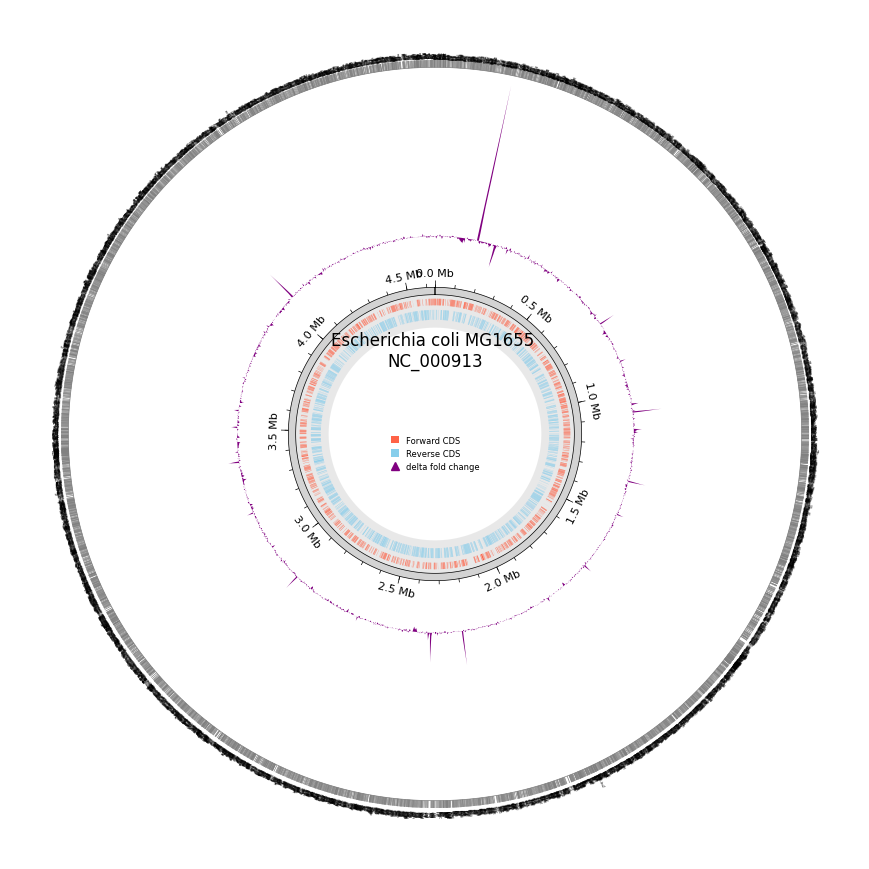

In [76]:
from pycirclize import Circos
from pycirclize.parser import Gff
from pycirclize.utils import load_prokaryote_example_file

ws, ss = 2000, 2000 

# Initialize Circos instance with genome size
circos = Circos(sectors={gbk.name: gbk.range_size})
circos.text(f"Escherichia coli MG1655 \nNC_000913\n", size=12, r=20)
sector = circos.sectors[0]

## load gff file
gff_file = load_prokaryote_example_file("escherichia_coli.gff.gz")
gff = Gff(gff_file)

major_ticks_interval = 500000
minor_ticks_interval = 100000

cds_name_track = sector.add_track((90, 100))
delta_fc_track = sector.add_track((45, 100), r_pad_ratio=0.1)

delta_fc_ = np.nan_to_num(occupancy_mean_LC-occupancy_mean_MG, nan=0.0, posinf=0.0, neginf=0.0)
pos_list_delta, fc_values_delta = sliding_mean(delta_fc_, ws, ss)

vmax = max(fc_values_delta)
vmin = min(fc_values_delta)
print (vmax, vmin)

delta_fc_track.fill_between(pos_list_delta, fc_values_delta, vmax = vmax, vmin = vmin, color = 'purple')

outer_track = sector.add_track((38, 40))
outer_track.axis(fc="lightgrey")
outer_track.xticks_by_interval(
    major_ticks_interval, label_formatter=lambda v: f"{v/ 10 ** 6:.1f} Mb"
)
outer_track.xticks_by_interval(minor_ticks_interval, tick_length=1, show_label=False)


circos.rect(r_lim=(29, 40), fc="lightgrey", ec="none", alpha=0.5)

f_cds_track = sector.add_track((35, 37), r_pad_ratio=0.1)
f_cds_track.genomic_features(gbk.extract_features("CDS", target_strand=1), fc="tomato")

r_cds_track = sector.add_track((31, 34), r_pad_ratio=0.1)
r_cds_track.genomic_features(gbk.extract_features("CDS", target_strand=-1), fc="skyblue")

pos_list, labels = [], []
for feat in gff.extract_features("gene"):
    start, end = int(str(feat.location.end)), int(str(feat.location.start))
    pos = (start + end) / 2
    label = feat.qualifiers.get("gene", [""])[0]
    pos_list.append(pos)
    labels.append(label)

cds_name_track.xticks(
    pos_list,
    labels,
    label_orientation="vertical",
    show_bottom_line=True,
    label_size=2,
    line_kws=dict(ec="grey"),
)

fig = circos.plotfig()

handles = [
    Patch(color="tomato", label="Forward CDS"),
    Patch(color="skyblue", label="Reverse CDS"),
    Line2D([], [], color="purple", label="delta fold change", marker="^", ms=6, ls="None"),
]
_ = circos.ax.legend(handles=handles, bbox_to_anchor=(0.5, 0.475), loc="center", fontsize=6)

plt.savefig("MG1655_labeled_delta_{0}_{1}.pdf".format(ws, ss), bbox_inches='tight')

_____________________